## File for Group Project: EDA on COVID-19 Dataset
### Authors (UH ID): 
### Abiha Fatima (1951259), Michael Bui (1413729), Tri Lam (1916079)

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [31]:
# Suppress warnings for clarity
import warnings
warnings.filterwarnings('ignore')

# Load the dataset (adjust path if needed)
data_path = "owid_covid_data.csv"
df = pd.read_csv(data_path)

# Filter out OWID-defined regions
substring = "OWID_"
df = df[~df['iso_code'].str.contains(substring)]

print(df.columns)
print(df.shape)


Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

### Task 1: Impact of COVID-19 on Countries (Cases and Deaths)

          Country  Total Cases  Total Deaths
0   United States  103436829.0     1193165.0
1           China   99373219.0      122326.0
2           India   45041748.0      533623.0
3          France   38997490.0      167985.0
4         Germany   38437756.0      174979.0
5          Brazil   37511921.0      702116.0
6     South Korea   34571873.0       35934.0
7           Japan   33803572.0       74694.0
8           Italy   26781078.0      197307.0
9  United Kingdom   24974629.0      232112.0


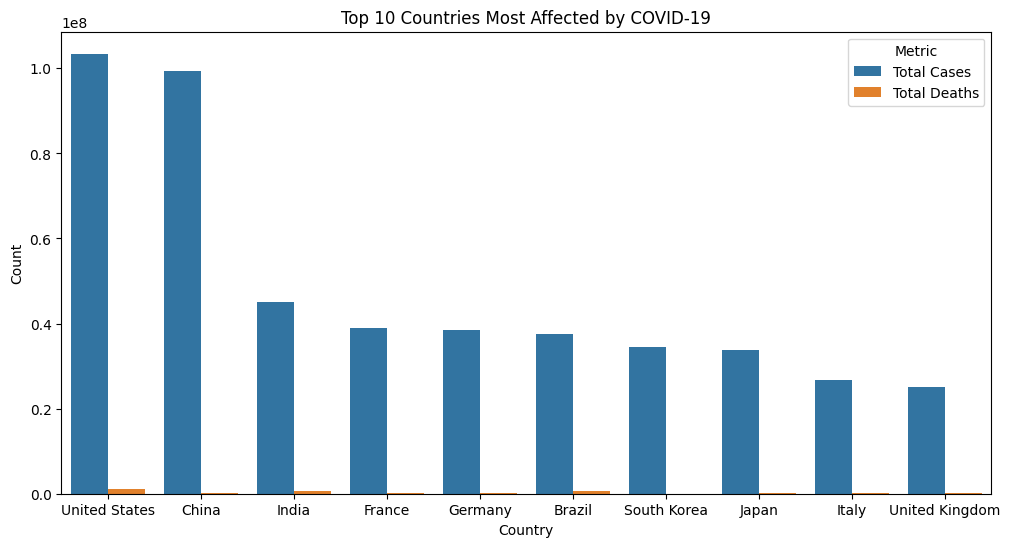

In [32]:
# Calculate total cases and deaths per country
total_cases = df.groupby('location')['new_cases'].sum().sort_values(ascending=False)
total_deaths = df.groupby('location')['new_deaths'].sum()

# Select the top 10 affected countries
affected_countries = total_cases.head(10).index
cases = total_cases.head(10).values
deaths = total_deaths[affected_countries].values

# Create a DataFrame for visualization
df_cases_deaths = pd.DataFrame({
    'Country': affected_countries,
    'Total Cases': cases,
    'Total Deaths': deaths
})
print(df_cases_deaths)

# Melt data for visualization
data_plot = pd.melt(df_cases_deaths, id_vars=['Country'], 
                    value_vars=['Total Cases', 'Total Deaths'], 
                    var_name='Metric', value_name='Count')

# Plot the data
plt.figure(figsize=(12, 6))
sns.barplot(x='Country', y='Count', hue='Metric', data=data_plot)
plt.title('Top 10 Countries Most Affected by COVID-19')
plt.show()


### Task 2: Testing Rates Across Countries

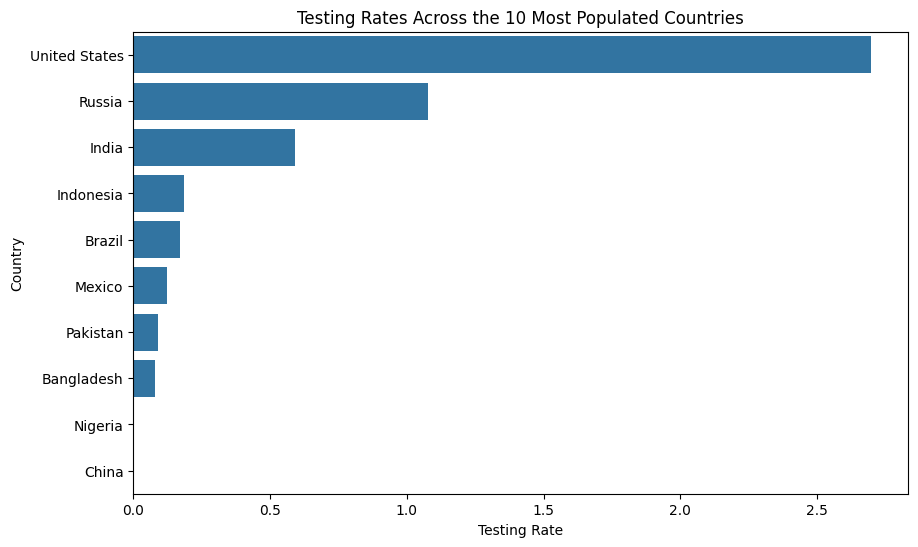

In [33]:
# Calculate most recent population and tests
df['date'] = pd.to_datetime(df['date'])
filtered_df = df[df['date'] <= '2022-06-23']
total_population = filtered_df.groupby('location')['population'].last()
total_tests = filtered_df.groupby('location')['new_tests'].sum()

# Get top 10 most populated countries
top_population = total_population.sort_values(ascending=False).head(10)
testing_rate = total_tests[top_population.index] / top_population

# Prepare data for visualization
testing_rate_df = pd.DataFrame({
    'Country': top_population.index,
    'Testing Rate': testing_rate
}).sort_values('Testing Rate', ascending=False)

# Plot the testing rates
plt.figure(figsize=(10, 6))
sns.barplot(y='Country', x='Testing Rate', data=testing_rate_df, orient='h')
plt.title('Testing Rates Across the 10 Most Populated Countries')
plt.show()


### Task 3: Comparing Rates of Increase in COVID-19 Between Two Countries

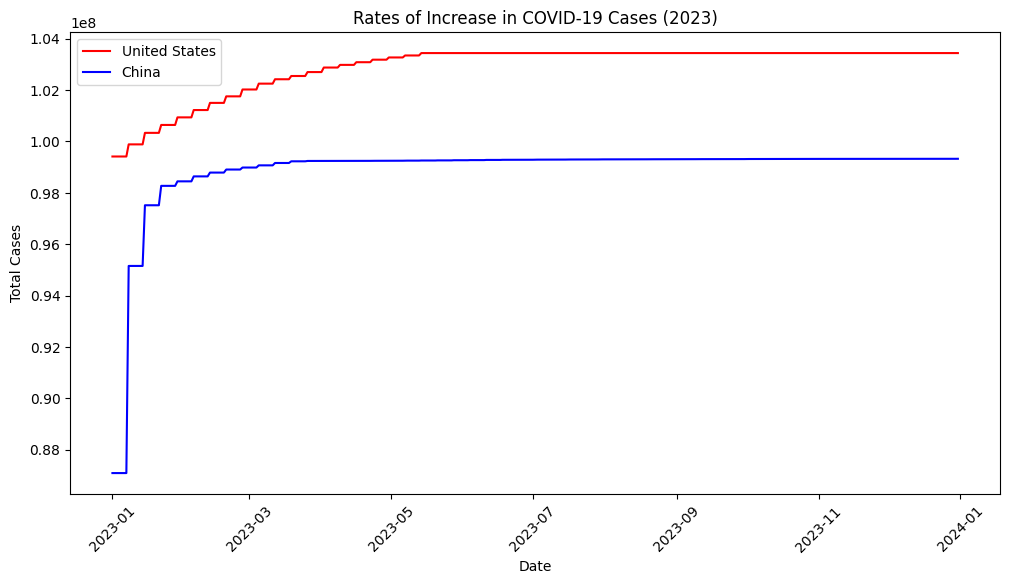

In [34]:
# Define countries of interest
country1 = "United States"
country2 = "China"

# Filter data for 2023 and selected countries
data_country1 = df[(df['location'] == country1) & (df['date'].dt.year == 2023)]
data_country2 = df[(df['location'] == country2) & (df['date'].dt.year == 2023)]

# Extract dates and cumulative cases
cases_country1 = data_country1[['date', 'total_cases']]
cases_country2 = data_country2[['date', 'total_cases']]

# Merge for comparison
comparison_df = pd.merge(cases_country1, cases_country2, on='date', suffixes=(f' ({country1})', f' ({country2})'))

# Plot the rates of increase
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['date'], comparison_df[f'total_cases ({country1})'], label=country1, color='red')
plt.plot(comparison_df['date'], comparison_df[f'total_cases ({country2})'], label=country2, color='blue')
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.title('Rates of Increase in COVID-19 Cases (2023)')
plt.legend()
plt.xticks(rotation=45)
plt.show()


### Task 4 Outlier Detection for key variables: new_cases, new_deaths, icu_patients, hosp_patients


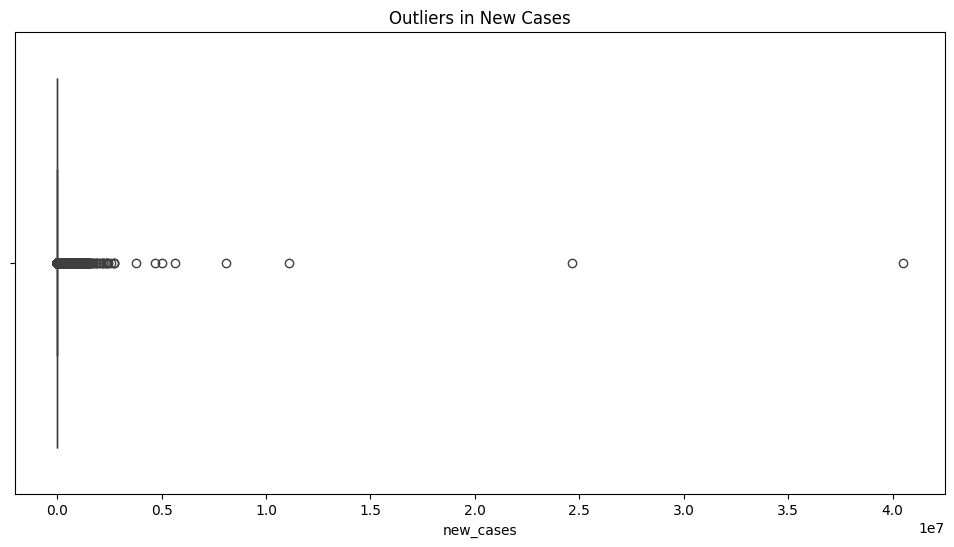

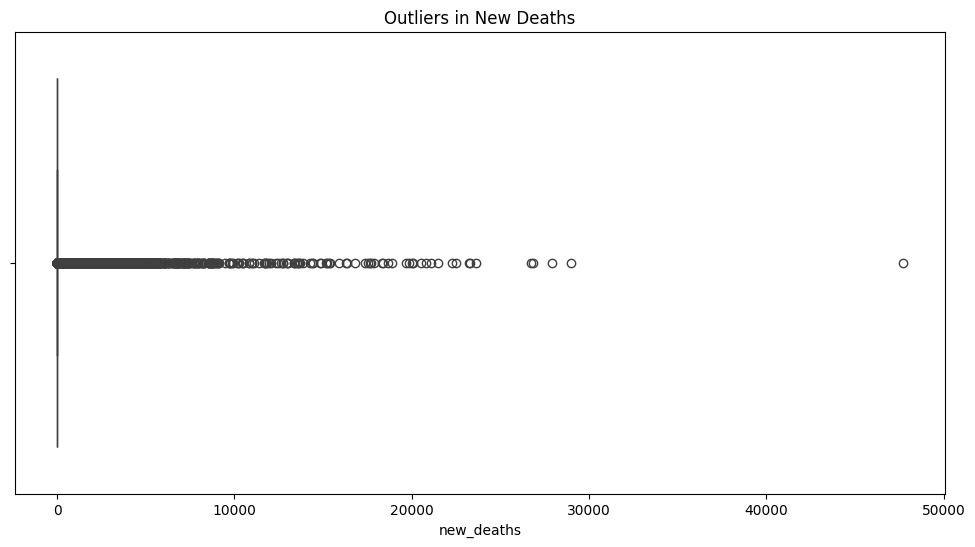

Outliers in New Cases:
             date     location  new_cases
56     2020-03-01  Afghanistan        1.0
70     2020-03-15  Afghanistan        6.0
77     2020-03-22  Afghanistan       17.0
84     2020-03-29  Afghanistan       67.0
91     2020-04-05  Afghanistan      183.0
...           ...          ...        ...
429385 2024-06-16     Zimbabwe        9.0
429392 2024-06-23     Zimbabwe        4.0
429399 2024-06-30     Zimbabwe        6.0
429406 2024-07-07     Zimbabwe        1.0
429420 2024-07-21     Zimbabwe        1.0

[38743 rows x 3 columns]

Outliers in New Deaths:
             date     location  new_deaths
84     2020-03-29  Afghanistan         2.0
91     2020-04-05  Afghanistan         3.0
98     2020-04-12  Afghanistan        10.0
105    2020-04-19  Afghanistan        15.0
112    2020-04-26  Afghanistan        13.0
...           ...          ...         ...
429210 2023-12-24     Zimbabwe         1.0
429224 2024-01-07     Zimbabwe         3.0
429231 2024-01-14     Zimbabwe     

In [35]:
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

# Detect outliers in new_cases
outliers_new_cases = detect_outliers(df, 'new_cases')

# Detect outliers in new_deaths
outliers_new_deaths = detect_outliers(df, 'new_deaths')

# Visualize outliers using box plots
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['new_cases'])
plt.title('Outliers in New Cases')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['new_deaths'])
plt.title('Outliers in New Deaths')
plt.show()

# Print outliers
print("Outliers in New Cases:")
print(outliers_new_cases[['date', 'location', 'new_cases']])

print("\nOutliers in New Deaths:")
print(outliers_new_deaths[['date', 'location', 'new_deaths']])

### Task 5 Regression: Predict ICU admissions (icu_patients) based on total_cases and total_deaths


Mean Squared Error: 3212821.4165087542
R^2 Score: 0.2861223349745191
Coefficients: [-0.00014819  0.01829657]


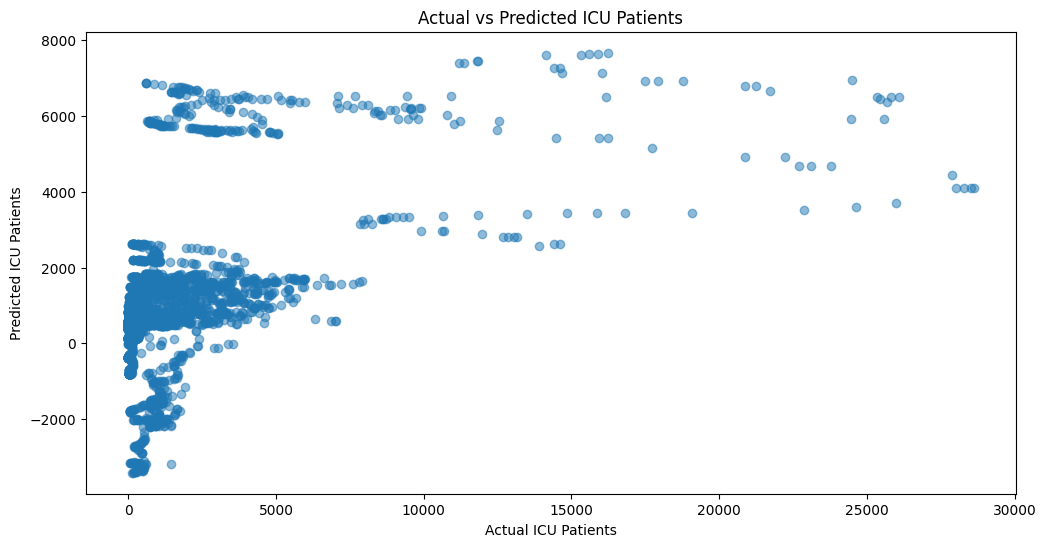

In [36]:
# Filter rows with non-null ICU patients
df_regression = df[['total_cases', 'total_deaths', 'icu_patients']].dropna()

# Prepare data for regression
X = df_regression[['total_cases', 'total_deaths']]
y = df_regression['icu_patients']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Coefficients
print("Coefficients:", model.coef_)

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual ICU Patients')
plt.ylabel('Predicted ICU Patients')
plt.title('Actual vs Predicted ICU Patients')
plt.show()


### Hospital need and rate

In [37]:
# Aggregate data to get one row per country
aggregated_df = df.groupby(['iso_code', 'location'], as_index=False).agg({
    'total_cases': 'sum',            # Sum total cases across all rows for each country
    'hosp_patients': 'sum'           # Sum hospitalized patients across all rows for each country
})

# Filter out rows where total_cases or hosp_patients are zero or missing
aggregated_df = aggregated_df[(aggregated_df['total_cases'] > 0) & (aggregated_df['hosp_patients'] > 0)]

# Calculate hospitalization rate
aggregated_df['hospitalization_rate'] = (aggregated_df['hosp_patients'] / aggregated_df['total_cases']) * 100

# Adjust bins for categorization based on actual hospitalization rate ranges
bins = [0, 0.01, 0.05, 0.1, float('inf')]  # Example: Very Low <0.01%, Low 0.01-0.05%, etc.
labels = ['Very Low', 'Low', 'Medium', 'High']
aggregated_df['hospitalization_need'] = pd.cut(aggregated_df['hospitalization_rate'], bins=bins, labels=labels, right=False)

# Save the updated dataset to a new CSV file (optional)
aggregated_df.to_csv('hospitalization_data.csv', index=False)

# Display a summary of the updated data
print(aggregated_df[['iso_code', 'location', 'total_cases', 'hospitalization_rate', 'hospitalization_need']].head())
print("Full output in hospitalization_data.csv")

   iso_code   location   total_cases  hospitalization_rate  \
11      AUS  Australia  9.324106e+09              0.019792   
12      AUT    Austria  5.308511e+09              0.026794   
15      BEL    Belgium  4.751573e+09              0.043223   
20      BGR   Bulgaria  1.351327e+09              0.030262   
28      BOL    Bolivia  1.220941e+09              0.030204   

   hospitalization_need  
11                  Low  
12                  Low  
15                  Low  
20                  Low  
28                  Low  
Full output in hospitalization_data.csv
